<a href="https://colab.research.google.com/github/RicoBasyar/Cyberbullying/blob/main/Cyberbullying_LSTM_TF_IDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install sastrawi

In [49]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import string, re
from wordcloud import WordCloud
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf
import nltk

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# **Dataset**

In [6]:
df = pd.read_csv('Dataset Rico.csv')

In [7]:
df = df.dropna()

In [8]:
df

,Komentar,label
0,"""Kaka tidur yaa, udah pagi, gaboleh capek2""",0
1,"""makan nasi padang aja begini badannya""",0
2,"""yang aku suka dari dia adalah selalu cukur je...",1
3,"""Hai kak Isyana aku ngefans banget sama kak Is...",0
4,"""Manusia apa bidadari sih herann deh cantik te...",0
...,...,...
1045,Bangga sama suami yg selalu ingat istri disela...,0
1046,Apaoun pekerjaannya yg penting halal u tuk men...,0
1047,Gojek itu mayoritas pegangguran yang lama gak ...,0
1048,<USERNAME> aslinya cantik dan ayu loh mbak kr...,0


In [9]:
print(df.label.value_counts())
plot = df.label.value_counts()
px.bar(plot)

0    525
1    525
Name: label, dtype: int64


# **Data Preprocessing**

## **Cleneaning Data**

In [10]:
def data_cleansing(text):
  text = text.lower()
  text = text.replace('username',' ')

  tb = string.punctuation
  trans = str.maketrans(tb,' '*len(tb))
  text = text.translate(trans)


  text = text.encode('ascii','ignore').decode('utf-8')
  text = re.sub(r'[^\x00-\x7f]',r'', text)

  text = text.replace('\n',' ')


  return text

In [11]:
df['Komentar'] = df['Komentar'].apply(data_cleansing)

In [12]:
df

,Komentar,label
0,kaka tidur yaa udah pagi gaboleh capek2,0
1,makan nasi padang aja begini badannya,0
2,yang aku suka dari dia adalah selalu cukur je...,1
3,hai kak isyana aku ngefans banget sama kak is...,0
4,manusia apa bidadari sih herann deh cantik te...,0
...,...,...
1045,bangga sama suami yg selalu ingat istri disela...,0
1046,apaoun pekerjaannya yg penting halal u tuk men...,0
1047,gojek itu mayoritas pegangguran yang lama gak ...,0
1048,aslinya cantik dan ayu loh mbak krn aku s...,0


## **Ubah Singkatan**

In [13]:
singkatan = pd.read_csv('kamus_singkatan.csv')
singkatan = singkatan.drop('Unnamed: 0', axis=1)

In [14]:
singkatan

,singkatan,asli
0,abgny,abangnya
1,abis,habis
2,ad,ada
3,adek,adik
4,adik2,adik-adik
...,...,...
1498,trm,terima
1499,tukeran,tukar
1500,tw,tahu
1501,yup,ya


In [15]:
new_row = [{'singkatan': 'in', 'asli': 'ini'},
            {'singkatan': 'ajg', 'asli': 'anjing'},
           {'singkatan': 'capek2', 'asli': 'capek capek'},
           {'singkatan': 'dimana2', 'asli': 'dimana mana'},
           {'singkatan': 'om2', 'asli': 'om om'},
           {'singkatan': 'bayi2', 'asli': 'bayi bayi'},
           {'singkatan': 'cakep2', 'asli': 'cakep cakep'}]
singkatan = singkatan.append(new_row, ignore_index=True)

<ipython-input-15-e60c46460bea>:8: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [16]:
singkatan

,singkatan,asli
0,abgny,abangnya
1,abis,habis
2,ad,ada
3,adek,adik
4,adik2,adik-adik
...,...,...
1505,capek2,capek capek
1506,dimana2,dimana mana
1507,om2,om om
1508,bayi2,bayi bayi


In [17]:
singkatan_dict = dict(zip(singkatan['singkatan'], singkatan['asli']))

def ubah_singkatan(text):
    for a, b in singkatan_dict.items():
        pattern = r"\b" + re.escape(a) + r"\b"
        text = re.sub(pattern, b, text)
    return text

In [18]:
df['Komentar'] = df['Komentar'].apply(ubah_singkatan)

In [19]:
df

,Komentar,label
0,kaka tidur yaa sudah pagi tidak boleh capek...,0
1,makan nasi padang saja begini badannya,0
2,yang saya suka dari dia adalah selalu cukur j...,1
3,hai kak isyana saya ngefans sekali sama kak i...,0
4,manusia apa bidadari sih herann deh cantik te...,0
...,...,...
1045,bangga sama suami yang selalu ingat istri dise...,0
1046,apaoun pekerjaannya yang penting halal u tuk m...,0
1047,gojek itu mayoritas pegangguran yang lama tida...,0
1048,aslinya cantik dan ayu loh mbak karena sa...,0


## **Stopword**

In [20]:
factory=StopWordRemoverFactory()
stopword=factory.create_stop_word_remover()

def stopwords(text):
  return stopword.remove(text)

In [21]:
df['Komentar'] = df['Komentar'].apply(stopwords)

In [22]:
df

,Komentar,label
0,kaka tidur yaa pagi boleh capek capek,0
1,makan nasi padang begini badannya,0
2,saya suka dia selalu cukur jembut manggung,1
3,hai kak isyana ngefans sekali sama kak isyana...,0
4,manusia apa bidadari sih herann deh cantik te...,0
...,...,...
1045,bangga sama suami selalu ingat istri disela wa...,0
1046,apaoun pekerjaannya penting halal u tuk menafk...,0
1047,gojek mayoritas pegangguran lama kerja terus h...,0
1048,aslinya cantik ayu loh mbak saya bertemu ...,0


## **Stemming**

In [23]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemming(text):
  return stemmer.stem(text)

In [24]:
df['Komentar'] = df['Komentar'].apply(stemming)

In [25]:
df

,Komentar,label
0,kaka tidur yaa pagi boleh capek capek,0
1,makan nasi padang begini badan,0
2,saya suka dia selalu cukur jembut manggung,1
3,hai kak isyana ngefans sekali sama kak isyana ...,0
4,manusia apa bidadari sih herann deh cantik terus,0
...,...,...
1045,bangga sama suami selalu ingat istri sela wakt...,0
1046,apaoun kerja penting halal u tuk nafkah keluar...,0
1047,gojek mayoritas pegangguran lama kerja terus h...,0
1048,asli cantik ayu loh mbak saya temu langsung se...,0


## **WordCloud**

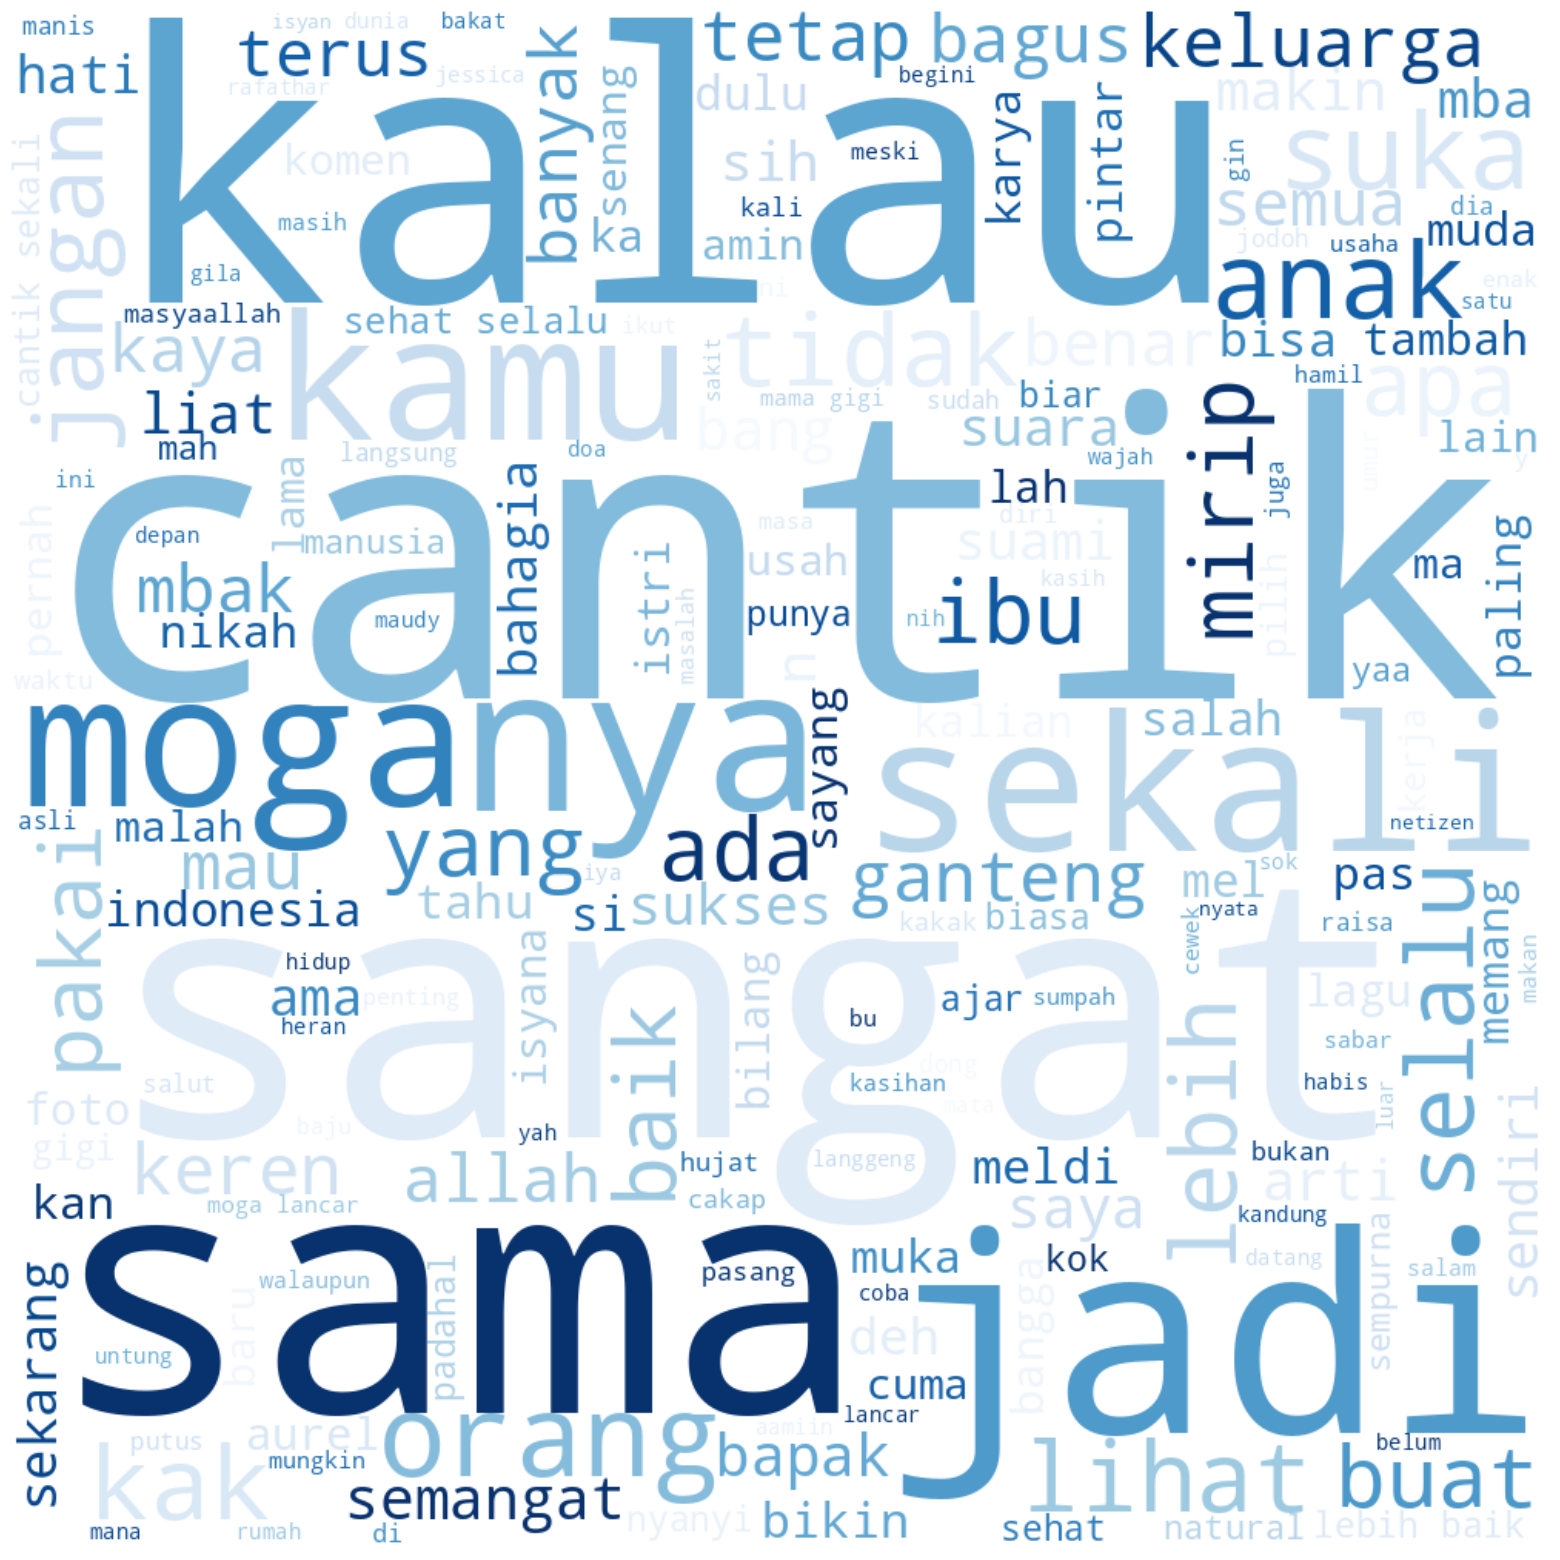

In [26]:
# value 0
trains0=df[df['label']==0]
all_text=' '.join(word for word in trains0['Komentar'])
word_cloud=WordCloud(colormap='Blues', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_text)
plt.figure(figsize=(20,20))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0, y=0)
plt.show()

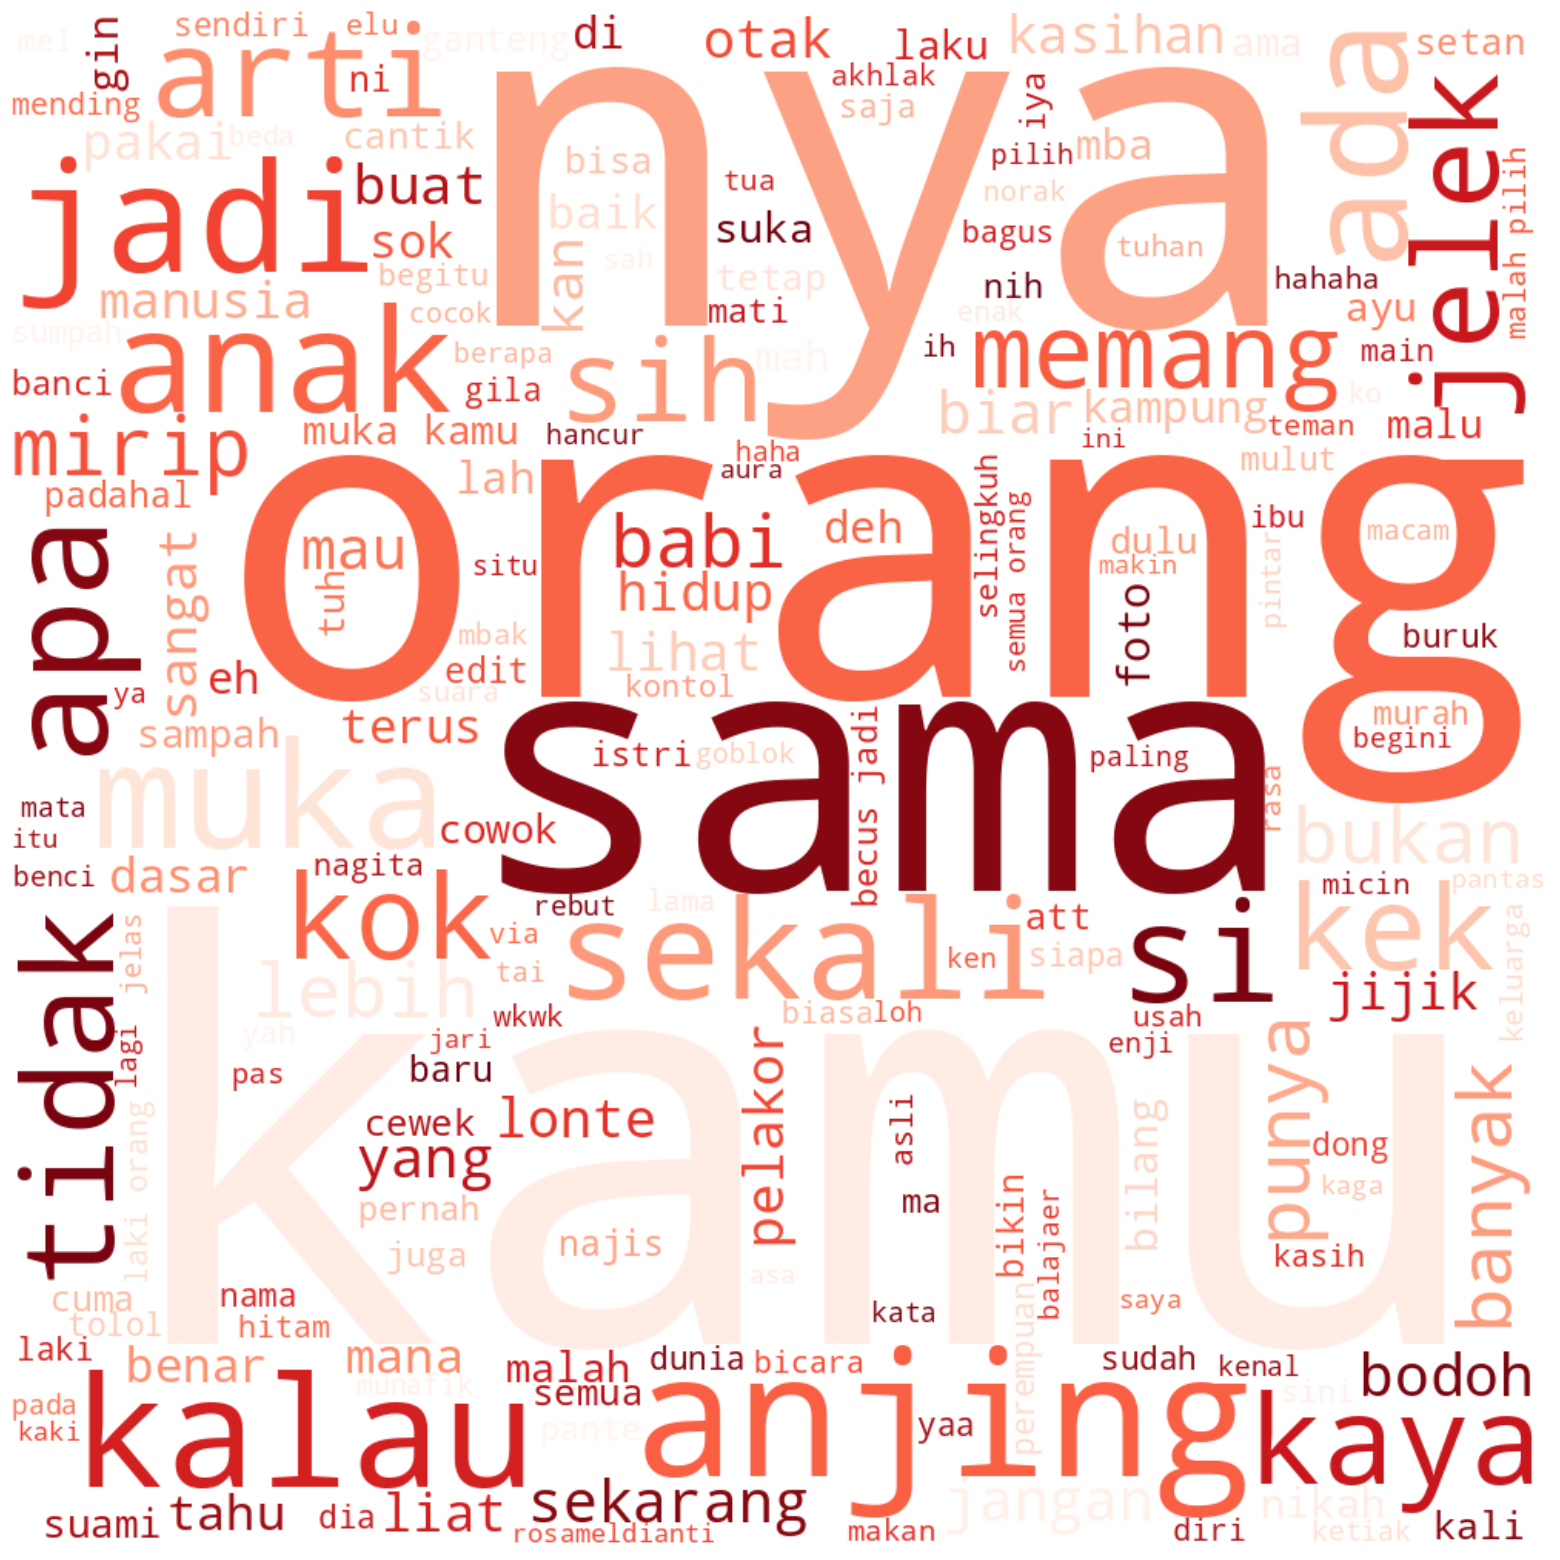

In [27]:
# value 1
trains1=df[df['label']==1]
all_text=' '.join(word for word in trains1['Komentar'])
word_cloud=WordCloud(colormap='Reds', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_text)
plt.figure(figsize=(20,20))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0, y=0)
plt.show()

# **TF-IDF**

In [28]:
x_train, x_test, y_train, y_test = train_test_split(df['Komentar'], df['label'], test_size=0.2, stratify=df['label'],
                                                    random_state=30)

vectorizer = TfidfVectorizer()
x_train_tfidf = vectorizer.fit_transform(x_train)
x_test_tfidf = vectorizer.transform(x_test)

# **LSTM**

In [33]:
# Convert the TF-IDF arrays to dense arrays
x_train_array = x_train_tfidf.toarray()
x_test_array = x_test_tfidf.toarray()

# Convert tf idf array ke dense array buat LSTM
num_features = x_train_array.shape[1]
x_train_lstm = np.reshape(x_train_array, (x_train_array.shape[0], 1, num_features))
x_test_lstm = np.reshape(x_test_array, (x_test_array.shape[0], 1, num_features))

# Convert label ke format binary
y_train_binary = np.array(y_train)
y_test_binary = np.array(y_test)

# cross validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=30)
cv_scores = []
for train_index, val_index in kfold.split(x_train_lstm, y_train_binary):
    # Bagi data ke training dan validation set
    x_train_fold, x_val_fold = x_train_lstm[train_index], x_train_lstm[val_index]
    y_train_fold, y_val_fold = y_train_binary[train_index], y_train_binary[val_index]

    # Model LSTM
    model = Sequential()
    model.add(LSTM(units=128, input_shape=(1, num_features)))
    model.add(Dense(units=1, activation='sigmoid'))

    # Compile model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train model
    model.fit(x_train_fold, y_train_fold, epochs=30, batch_size=64, verbose=0)

    # Evaluasi model di validation set
    _, accuracy = model.evaluate(x_val_fold, y_val_fold)
    cv_scores.append(accuracy)

# Nilai scross validation rata rata dan standard deviasi
mean_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)
print("Cross-Validation Accuracy: {:.4f} (+/- {:.4f})".format(mean_cv_score, std_cv_score))

# Evaluasi model
test_loss, test_accuracy = model.evaluate(x_test_lstm, y_test_binary)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

6/6 [==============================] - 0s 5ms/step - loss: 0.4117 - accuracy: 0.8214
Cross-Validation Accuracy: 0.8381 (+/- 0.0295)
7/7 [==============================] - 0s 5ms/step - loss: 0.2757 - accuracy: 0.8905
Test Loss: 0.27569079399108887
Test Accuracy: 0.8904761672019958


In [108]:
def preprocess_unseen_data(text):
    text = data_cleansing(text)
    text = ubah_singkatan(text)
    text = stopwords(text)
    text = stemming(text)
    return text

def preprocess_and_predict(unseen_data):
    preprocessed_data = preprocess_unseen_data(unseen_data)
    tfidf_features = vectorizer.transform([preprocessed_data])
    tfidf_features_array = tfidf_features.toarray()
    num_features = tfidf_features_array.shape[1]
    tfidf_features_lstm = np.reshape(tfidf_features_array, (1, 1, num_features))
    predictions = model.predict(tfidf_features_lstm)
    predicted_classes = (predictions > 0.95).astype(int)
    if predictions > 0.95 :
      print("Cyberbullying")
    else:
      print("Tidak Cyberbullying")

    return predicted_classes[0], predictions

In [119]:
pos = 'lu orang kok goblok banget gitu aja ga bisa'
net = 'kerjanya bagus banget pinter ngatur waktu'
print(preprocess_unseen_data(pos))
print('Hasil : ', preprocess_and_predict(pos))
print(preprocess_unseen_data(net))
print('Hasil : ', preprocess_and_predict(net))

kamu orang kok goblok sekali saja bisa
1/1 [==============================] - 0s 29ms/step
Cyberbullying
Hasil :  (array([1]), array([[0.963054]], dtype=float32))
kerja bagus sekali pintar ngatur waktu
1/1 [==============================] - 0s 20ms/step
Tidak Cyberbullying
Hasil :  (array([0]), array([[0.19674096]], dtype=float32))
